# LSTM and Glove Embeddings

Works on Colab

In [30]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import pickle

import re
import nltk
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Embedding, Input, Dropout, Bidirectional, Flatten, Conv1D, GlobalMaxPool1D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

from gensim.models.word2vec import Word2Vec
import gensim.downloader

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kalya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Just using text

In [2]:
df_train = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")

train = df_train.drop(columns=['id','keyword','location'])
test =  df_test.drop(columns=['id','keyword','location'])


In [3]:
def tweet_cleaner(tweet , remove_usernames = True):
  '''
  made for cleaning the tweet

  input: tweet: an uncleaned tweet with a 'string datatype
         remove_usernames: bool if usernames should be included or not. even if included, @ symbol is removed

  output: cleaned tweet with all stopwords removed

  '''
  #first remove usernames
  if remove_usernames:
    tweet = re.sub('@[^\s]+','',tweet)

  # remove urls
  tweet = re.sub('http[^\s]+','',tweet)
  tweet = re.sub('https[^\s]+','',tweet)
  tweet = re.sub('www[^\s]+','',tweet)

  # just capture words
  pattern = r'\b[a-zA-Z]+\b'

  # including new stopwords unique to tweets. and adding them to nltk
  stops = nltk.corpus.stopwords.words('english')
  new_stop_words = ["ha", "wa", "http", "s", "https", "com", "'s", "' s", "'ll", "' ll", "' d", "'d", "'re", "' re", "co", "amp", "url"]
  stops.extend(new_stop_words)

  # Gets list of words from re.findall() and filters out stop words and 1 letter words
  list_of_words = [x.lower() for x in re.findall(pattern, tweet) if (x not in stops) and (len(x)>1)]

  return ' '.join(list_of_words)



In [4]:
train['text_cleaned'] = train['text'].apply(tweet_cleaner)
test['text_cleaned'] = test['text'].apply(tweet_cleaner)
train.sample(5)

,text,target,text_cleaned
451,it scares me that there's new versions of nucl...,1,scares new versions nuclear attack warnings li...
6700,Please please u gotta listen to @leonalewis # ...,0,please please gotta listen essenceofme thunder...
2102,RSS: Judge orders Texas to recognize spouse on...,0,rss judge orders texas recognize spouse sex de...
688,@BaseballQuotes1 I have a 32 inch dynasty,0,inch dynasty
7556,The Twitter update pretty much wrecked the app,0,the twitter update pretty much wrecked app


## Using [this](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html) to map text to vectors


In [22]:
# i want to make the tokenizer and embedding matrix have as much information.
# so I'm using all data availabke to do that.
tokenizer = Tokenizer(num_words=10_000)
tokenizer.fit_on_texts(train['text_cleaned'])
sequences =tokenizer.texts_to_sequences(train['text_cleaned'])

word_index = tokenizer.word_index
print('Found %s unique words (tokens).' % len(word_index))

data = pad_sequences(sequences, maxlen=25) # determined this by finding the max len of a sequence
labels = np.asarray(train['target'])

print('Shape of data:', data.shape)
print('Shape of label:', labels.shape)


Found 13809 unique words (tokens).
Shape of data: (7613, 25)
Shape of label: (7613,)


# Preparing the embedding layer

text file with glove embeddings gotten from [https://nlp.stanford.edu/projects/glove/](https://nlp.stanford.edu/projects/glove/)

In [12]:
embeddings_index = {} # creating a dictionary

glove_path = '../glove/glove.twitter.27B.100d.txt'


with open(glove_path, encoding='utf-8') as glove_file:
    for line in glove_file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


## ok now there we have an embeddings dictionary where the keys are the 1,193,514 unique words and the values are the 25 dimension vectors that each word is represented by

At this point we can leverage our embedding_index dictionary and our word_index to compute our embedding matrix:


In [11]:
len(tokenizer.word_index)

13809

In [23]:
num_words_in_glove = 0
embedding_dim= 100
embedding_matrix = np.zeros((len(word_index)+1, embedding_dim))

# iterating through the tokenizer.word_index ( all of our unique words: 13809 uniques)
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word) # using get because if word isnt in glove, returns None
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        num_words_in_glove +=1
print(f'Total number of words from Glove: {num_words_in_glove}')

Total number of words from Glove: 12326


In [24]:
embedding_matrix.shape

(13810, 100)

embedding_matrix is now filled with a mapping of words(tokens) from our corpus into the vectors from GloVe

# Keras LSTM

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    data, # padded sequences where the words are tokenized with tokenizer.word_index
    labels, # np.asarray(train['target'])
    random_state = 214,
    stratify=labels
    )

In [41]:
X_train.shape

(5709, 25)

In [42]:
from sklearn.metrics.pairwise import kernel_metrics
model = Sequential()
model.add(Embedding(len(word_index) + 1, # input dim = max_words
                    embedding_dim, # output dim = dim of glove vectors
                    input_length=25, # input_length=max_sequence_length
                    weights=[embedding_matrix],
                    trainable=False)
)
model.add(Bidirectional(LSTM(128, return_sequences = True)))
model.add(Bidirectional(LSTM(128, return_sequences = True)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 25, 100)           1381000   
                                                                 
 bidirectional_7 (Bidirecti  (None, 25, 256)           234496    
 onal)                                                           
                                                                 
 bidirectional_8 (Bidirecti  (None, 25, 256)           394240    
 onal)                                                           
                                                                 
 flatten_1 (Flatten)         (None, 6400)              0         
                                                                 
 dense_8 (Dense)             (None, 64)                409664    
                                                                 
 dropout_3 (Dropout)         (None, 64)               

In [43]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train,
          y_train,
          validation_data = (X_test, y_test),
          epochs=4,
          batch_size=32)


Epoch 1/4
179/179 [==============================] - 20s 73ms/step - loss: 0.4912 - accuracy: 0.7726 - val_loss: 0.4456 - val_accuracy: 0.8015
Epoch 2/4
179/179 [==============================] - 11s 60ms/step - loss: 0.4412 - accuracy: 0.8080 - val_loss: 0.4332 - val_accuracy: 0.8114
Epoch 3/4
179/179 [==============================] - 11s 62ms/step - loss: 0.4253 - accuracy: 0.8170 - val_loss: 0.4395 - val_accuracy: 0.8083
Epoch 4/4
179/179 [==============================] - 11s 59ms/step - loss: 0.3969 - accuracy: 0.8296 - val_loss: 0.4335 - val_accuracy: 0.8067


Save the history of 20 epochs for later so that we can get nice graphs

# dont run the bottom cell

In [39]:
epoch_plotting = history

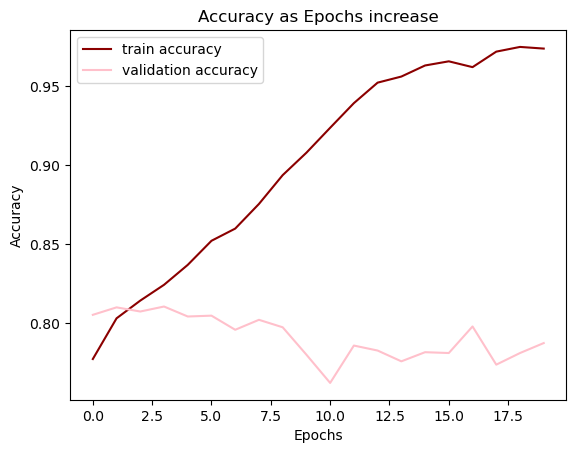

In [47]:
plt.plot(epoch_plotting.history['accuracy'], label='train accuracy',  color='darkred')
plt.plot(epoch_plotting.history['val_accuracy'], label='validation accuracy',color='pink')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim((0,1))
plt.title('Accuracy as Epochs increase')
plt.legend();

#### first, testing to see if model.predict works as expected for just 1 tweet

a function to clean tweets and put them in a format for the model to predict with

In [48]:
def tweet_to_input(tweet,tokenizer=tokenizer):
  '''
  Function that transforms asingle tweet(string) into an input for the model that was trained with a particular tokenizer
  input: tweet = single tweet that is a string
         tokenizer = tensorflow tokenizer used to train the model that we are getting predicitons from

  output: input array for model of shape (,max_padded_sequence_length)  aka (1,25) for this particular model

  requires:
            - tweet_cleaner() custom function
            - tensorflow.keras.preprocessing.Tokenizer object that was used in model training
            - pad_sequences() function from tensorflow.keras.preprocessing.sequence

  '''

  cleaned_tweet = list(map(tweet_cleaner,[tweet]))

  sequence = tokenizer.texts_to_sequences(cleaned_tweet)

  padded_array = pad_sequences(sequence, maxlen=25)

  return padded_array



In [51]:
inp = tweet_to_input("Israel-Hamas war rages as Palestinian death toll rises in Gaza: Live updates" ,tokenizer=tokenizer)

model.predict(inp)[0][0]

1/1 [==============================] - 0s 27ms/step


0.99673754

In [44]:
with open('../pickles/arjun_model_3.pkl', 'wb') as file:
    pickle.dump(model, file)

with open('../pickles/tokenizer_arjun_v1.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)
